# Libraries

In [1]:
import pandas as pd
import xgboost
import sklearn

In [2]:
print('-'*16)
print('*** Versions ***')
print('-'*16)
print(f'pandas=={pd.__version__}')
print(f'sklearn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')

----------------
*** Versions ***
----------------
pandas==1.5.3
sklearn==1.3.0
xgboost==1.7.3


# Load data / define features

In [3]:
dataset =  pd.read_csv('../data/raw/train.csv',index_col='id')

cat_ft = ['Type','Product ID']
drop_ft = 'RNF'
num_ft = ['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
bin_ft = ['TWF','HDF','PWF','OSF']
target = 'Machine failure'
#machine = 'Product ID'

# Preprocessors

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

### Drop

In [5]:
class DropUnecessaryFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, variables=None):
        self.variables = variables
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X = X.drop(self.variables, axis=1)
        
        return X
    
test = DropUnecessaryFeatures(drop_ft)
test.fit_transform(dataset).head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF
id,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0


### Numerical

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

class NumericalPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, variables=None):
        self.variables = variables
        
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = StandardScaler()
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        X[self.variables] = self.imputer.fit_transform(X[self.variables])
        X[self.variables] = self.scaler.fit_transform(X[self.variables])
        
        return X
    
test = NumericalPreprocessor(num_ft)
test.fit_transform(dataset).head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,0.395880,-0.246230,0.545416,-0.499711,0.556417,0,0,0,0,0,0
1,M20343,M,1.469856,1.558605,1.720308,-1.323028,1.494433,0,0,0,0,0,0
2,L49454,L,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,0,0,0,0,0,0
3,L53355,L,0.610675,0.692284,0.026445,0.464745,1.447532,0,0,0,0,0,0
4,M24050,M,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,0,0,0,0,0,0


### Categorical

In [7]:
from sklearn.preprocessing import OrdinalEncoder

class CatBinPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, cat_ft=None, bin_ft=None):
        self.cat_ft = cat_ft
        self.bin_ft = bin_ft
        
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy='most_frequent')
        self.encoder = OrdinalEncoder()
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        X[self.cat_ft + self.bin_ft] = self.imputer.fit_transform(X[self.cat_ft + self.bin_ft])
        X[self.cat_ft] = self.encoder.fit_transform(X[self.cat_ft])
        
        for feat in self.bin_ft:
            X[feat] = X[feat].astype('int')
        
        return X
    
test = CatBinPreprocessor(cat_ft,bin_ft)
test.fit_transform(dataset).head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,2752.0,1.0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,8620.0,2.0,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2344.0,1.0,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,4704.0,1.0,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,9727.0,2.0,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


### New Features

In [8]:
class CreateNewFeatures(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        X['Temperature ratio'] = X['Process temperature [K]'] * X['Air temperature [K]']
        X['Mechanical ratio'] = X['Torque [Nm]'] * X['Rotational speed [rpm]']
        
        return X
    
test = CreateNewFeatures()
test.fit_transform(dataset).head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temperature ratio,Mechanical ratio
id,,,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,93065.76,57615.6
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,94441.46,51186.9
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,92334.05,47832.5
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,93580.90,67513.2
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,92082.00,58091.4


### Clean names

In [9]:
class CleanFeatureNames(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        self.columns = X.columns
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        new_columns = []
        for name in self.columns:
            new_columns.append(
                name.replace('[','(').replace(']',')'))
            
        X.columns = new_columns
        return X
    
test = CleanFeatureNames()
test.fit_transform(dataset).head()

,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


# Pipeline

In [10]:
from sklearn.model_selection import train_test_split

X = dataset.drop(target,axis=1)
y = dataset[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

def pipeline(cat_ft,drop_ft,num_ft,bin_ft,model_params):
    
    match_pipe = Pipeline([
        ('drop_features', DropUnecessaryFeatures(drop_ft)),
        ('numerical', NumericalPreprocessor(num_ft)),
        ('categorical', CatBinPreprocessor(cat_ft,bin_ft)),
        ('new_features', CreateNewFeatures()),
        ('clean_names', CleanFeatureNames()),
        ('clasifier', XGBClassifier(
            n_estimators = model_params['n_estimators'],
            max_depth = model_params['max_depth'],
            gamma = model_params['gamma'],
            colsample_bytree = model_params['colsample_bytree'],
            reg_lambda = model_params['reg_lambda'],
            min_child_weight = model_params['min_child_weight'],
            random_state = model_params['random_state']
    ))
    ])
    
    return match_pipe

model_params = {
    'colsample_bytree': 0.48278853482586565,
    'gamma': 3.1544797990898688,
    'max_depth': 18,
    'min_child_weight': 2.0,
    'n_estimators': int(192.0151373878645),
    'reg_lambda': 0.9215303383104446,
    'random_state': 42}

match_pipe = pipeline(cat_ft,drop_ft,num_ft,bin_ft,model_params)
match_pipe.fit(X_train,y_train)

Pipeline(steps=[('drop_features', DropUnecessaryFeatures(variables='RNF')),
                ('numerical',
                 NumericalPreprocessor(variables=['Air temperature [K]',
                                                  'Process temperature [K]',
                                                  'Rotational speed [rpm]',
                                                  'Torque [Nm]',
                                                  'Tool wear [min]'])),
                ('categorical',
                 CatBinPreprocessor(bin_ft=['TWF', 'HDF', 'PWF', 'OSF'],
                                    cat_ft=['Type', 'Product ID'])),
                ('new_features', CreateNewFeatures(...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=18, max_leaves=None,
                               min_child_weight=2.0, missing=nan,
                               monotone_constraints=None, n_estimators=192,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26848
           1       0.98      0.77      0.87       438

    accuracy                           1.00     27286
   macro avg       0.99      0.89      0.93     27286
weighted avg       1.00      1.00      1.00     27286



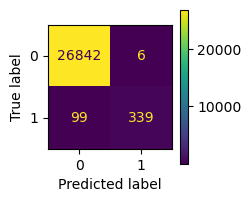

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds = match_pipe.predict(X_test)

def conf_matrix(y_true,y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true,y_pred)

    fig, ax = plt.subplots(figsize=(2, 2))

    # Create a ConfusionMatrixDisplay object and plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    plt.show()
    
print(classification_report(y_test,preds))
conf_matrix(y_test,preds)